# Cell-Cell Interaction Analysis with CellChat

2025-07-22

## Load required libraries

In [1]:
library(Seurat)
library(CellChat)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:Seurat’:

    components


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



## Load the Data

In [2]:
seurat <- readRDS("/BiO/data/HLCA_pulmonary_fibrosis_immune.rds")
seurat

An object of class Seurat 
19354 features across 7782 samples within 1 assay 
Active assay: RNA (19354 features, 0 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, umap, harmony, umap.harmony

## UMAP visualization

In [3]:
options(repr.plot.width =  5, repr.plot.height = 4, repr.plot.res = 200)

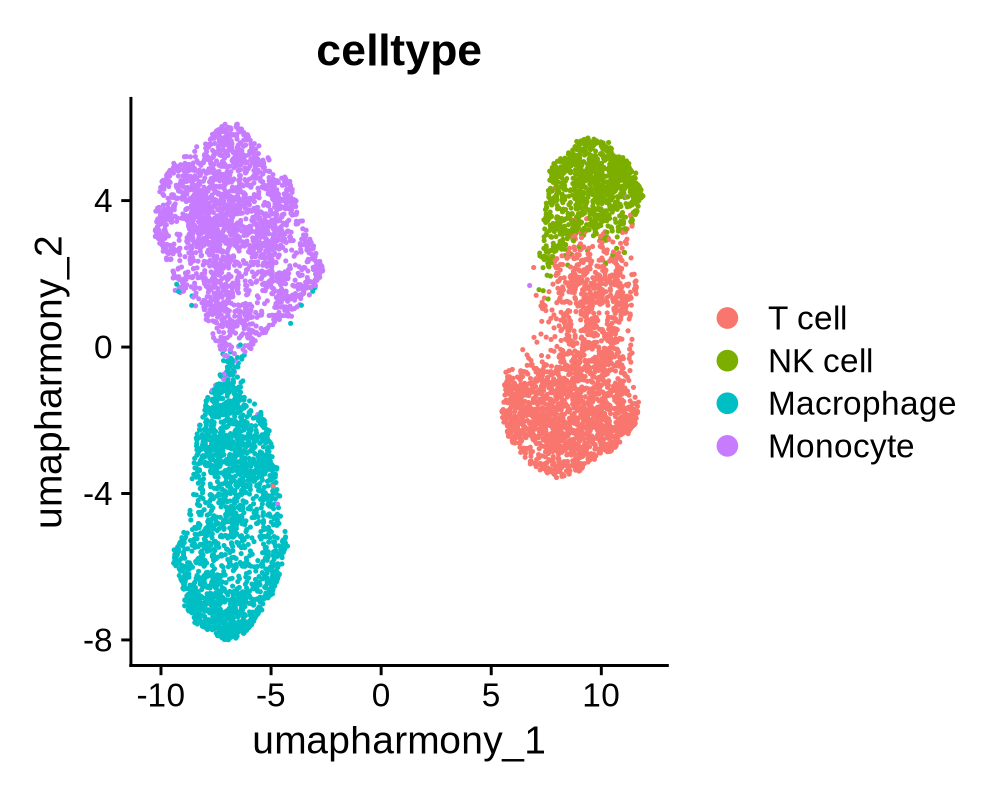

In [4]:
DimPlot(seurat, group.by = 'celltype', reduction = "umap.harmony")

In [5]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)

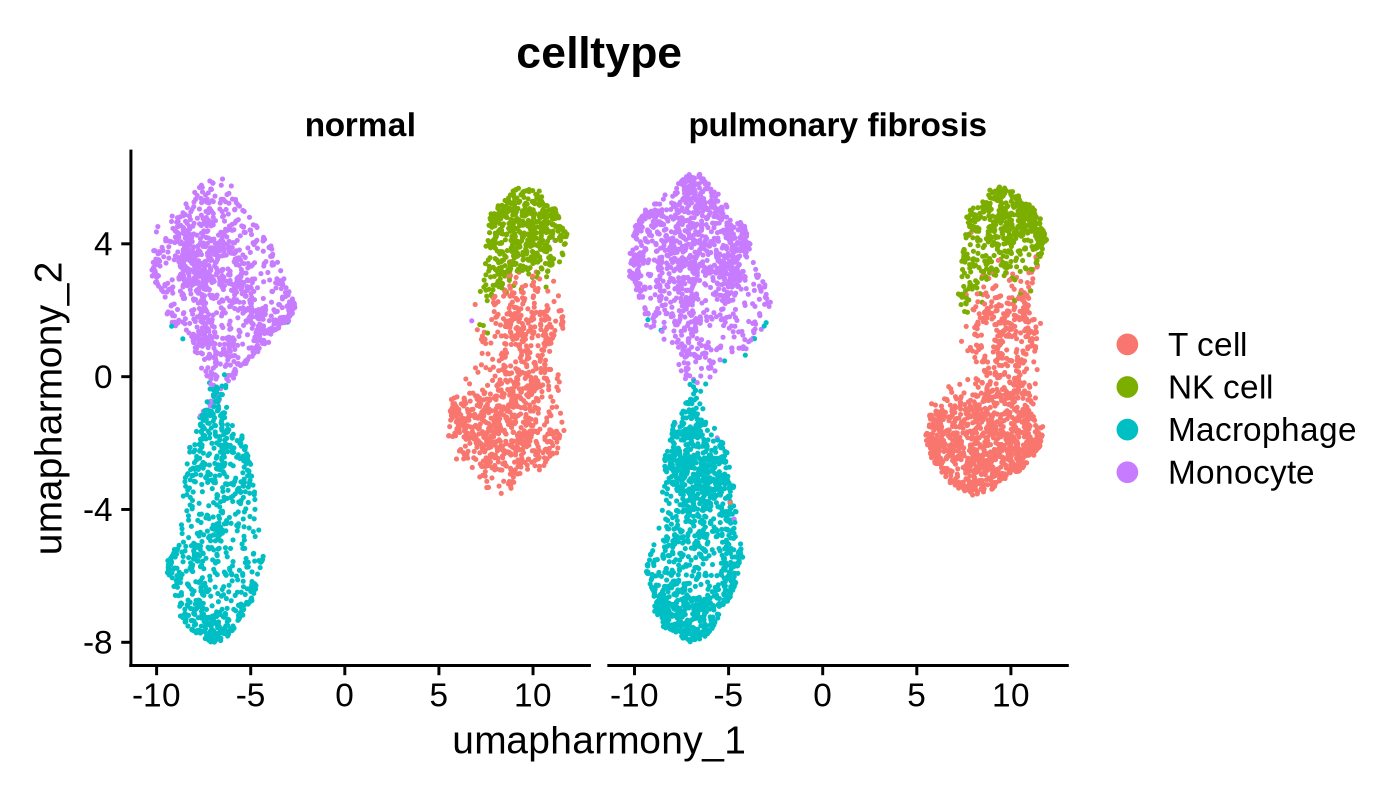

In [6]:
DimPlot(seurat, group.by = 'celltype', reduction = "umap.harmony", split.by = "disease")

## Input data processing

### 1-1. Create CellChat object from Seurat object

In [7]:
seurat_PF <- subset(seurat, subset = disease == "pulmonary fibrosis")
cellchat_PF <- createCellChat(object = seurat_PF, group.by = "celltype", assay = "RNA")

[1] "Create a CellChat object from a Seurat object"
The `meta.data` slot in the Seurat object is used as cell meta information 


Warning message in createCellChat(object = seurat_PF, group.by = "celltype", assay = "RNA"):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  T cell, NK cell, Macrophage, Monocyte 


### 1-2. Create CellChat object from expression matrix and metadata

In [8]:
expr <- seurat[["RNA"]]$data
meta <- seurat@meta.data

cells_PF <- rownames(meta)[meta$disease == "pulmonary fibrosis"]

expr_PF <- expr[, cells_PF]
meta_PF <- meta[cells_PF,]
meta_PF$celltype <- as.character(meta_PF$celltype)

cellchat_PF <- createCellChat(object = expr_PF, meta = meta_PF, group.by = "celltype")

[1] "Create a CellChat object from a data matrix"


Warning message in createCellChat(object = expr_PF, meta = meta_PF, group.by = "celltype"):
“The 'meta' data does not have a column named `samples`. We now add this column and all cells are assumed to belong to `sample1`! 
”


Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Macrophage, Monocyte, NK cell, T cell 


### 2. Set the ligand-receptor interaction database

In [9]:
options(repr.plot.width = 6, repr.plot.height = 4, repr.plot.res = 200)

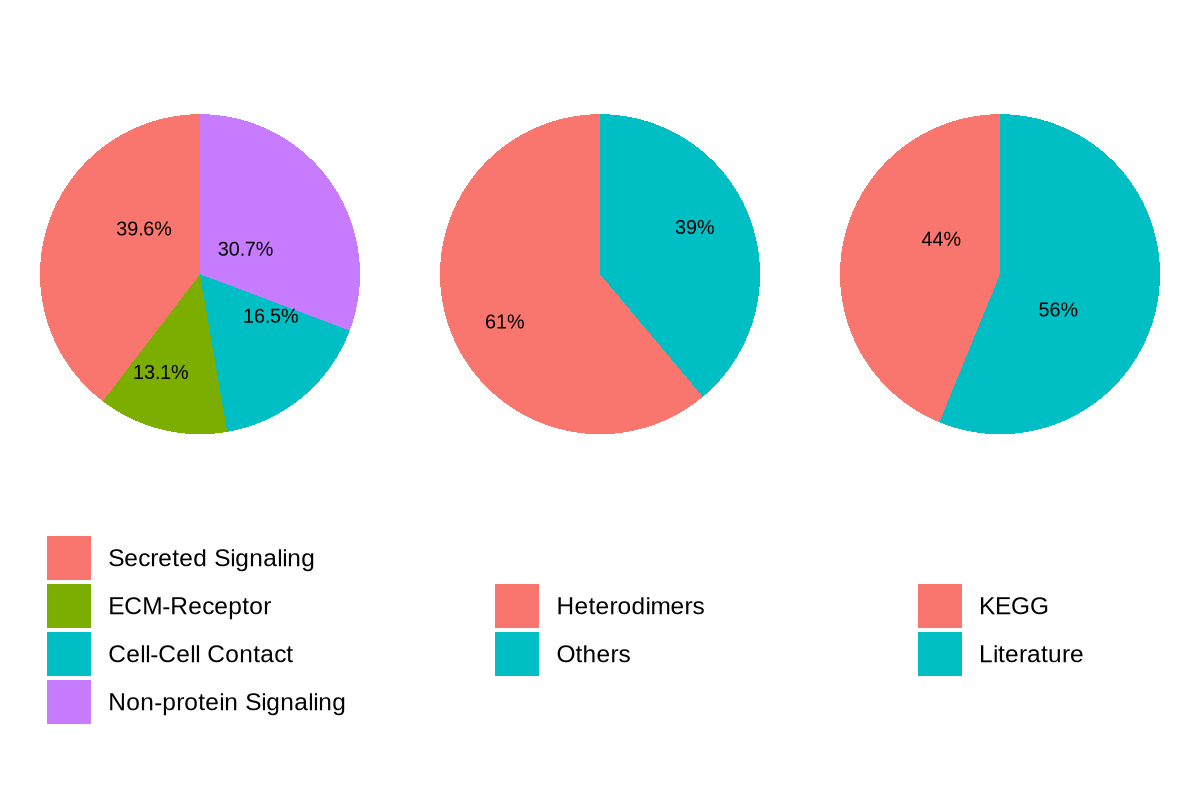

In [10]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

### 3. Subset the expression data using CellChatDB genes

In [11]:
cellchat_PF@DB <- CellChatDB
cellchat_PF <- subsetData(cellchat_PF)

### 4. Identify over-expressed ligands/receptors and L-R interactions in each cell group

In [12]:
cellchat_PF <- identifyOverExpressedGenes(cellchat_PF)
cellchat_PF <- identifyOverExpressedInteractions(cellchat_PF)

The number of highly variable ligand-receptor pairs used for signaling inference is 874 


### 5. (Optional) Smooth the gene expression because of shallow sequencing depth

In [13]:
cellchat_PF <- smoothData(cellchat_PF, adj = PPI.human)

## Inference of cell-cell communication networks

### 1. Compute the communication probability

In [14]:
cellchat_PF <- computeCommunProb(cellchat_PF, raw.use = FALSE) # Set raw.use = FALSE to use the smoothed data

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-07-19 21:35:12.929313]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-07-19 21:37:13.143503]"


### 2. Filter the cell-cell interaction, based on the number of cells in each group

In [15]:
cellchat_PF <- filterCommunication(cellchat_PF, min.cells = 0)

### 3. Extract the inferred cellular communication network as a data frame

In [16]:
df_net_PF <- subsetCommunication(cellchat_PF)
head(df_net_PF)

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,Macrophage,Macrophage,TGFB1,TGFbR1_R2,0.001770137,0.00,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350
2,Monocyte,Macrophage,TGFB1,TGFbR1_R2,0.001466371,0.00,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350
3,NK cell,Macrophage,TGFB1,TGFbR1_R2,0.001517727,0.00,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350
4,Macrophage,Monocyte,TGFB1,TGFbR1_R2,0.001699504,0.00,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350
5,Monocyte,Monocyte,TGFB1,TGFbR1_R2,0.001407818,0.01,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350
6,NK cell,Monocyte,TGFB1,TGFbR1_R2,0.001457154,0.01,TGFB1_TGFBR1_TGFBR2,TGFB1 - (TGFBR1+TGFBR2),TGFb,Secreted Signaling,KEGG: hsa04350


### 4. Infer the cell-cell communication at a signaling pathway level

In [17]:
cellchat_PF <- computeCommunProbPathway(cellchat_PF)

### 5. Calculate the aggregated cell-cell communication network

In [18]:
cellchat_PF <- aggregateNet(cellchat_PF)

### 6. Save the CellChat object

In [19]:
saveRDS(cellchat_PF, file = "cellchat_lung_PF.rds")

## Visualization

### Circle plot

In [20]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

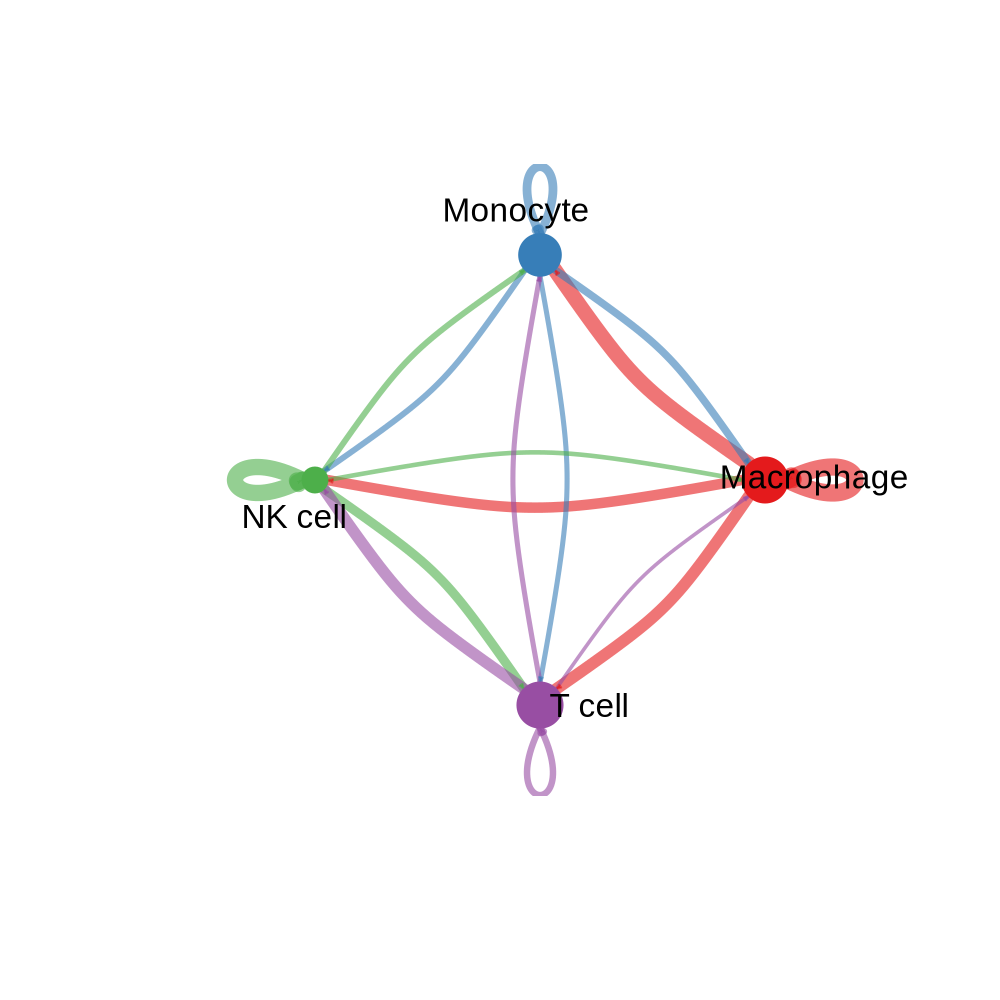

In [21]:
groupSize_PF <- as.numeric(table(cellchat_PF@idents))
plot <- netVisual_circle(cellchat_PF@net$weight, vertex.weight = groupSize_PF, weight.scale = T, label.edge= F)

## Identify signaling roles and major contributing signaling

### 1. Compute the network centrality scores

In [22]:
cellchat_PF <- netAnalysis_computeCentrality(cellchat_PF, slot.name = "netP")

### 2. Visualization

In [23]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 300)

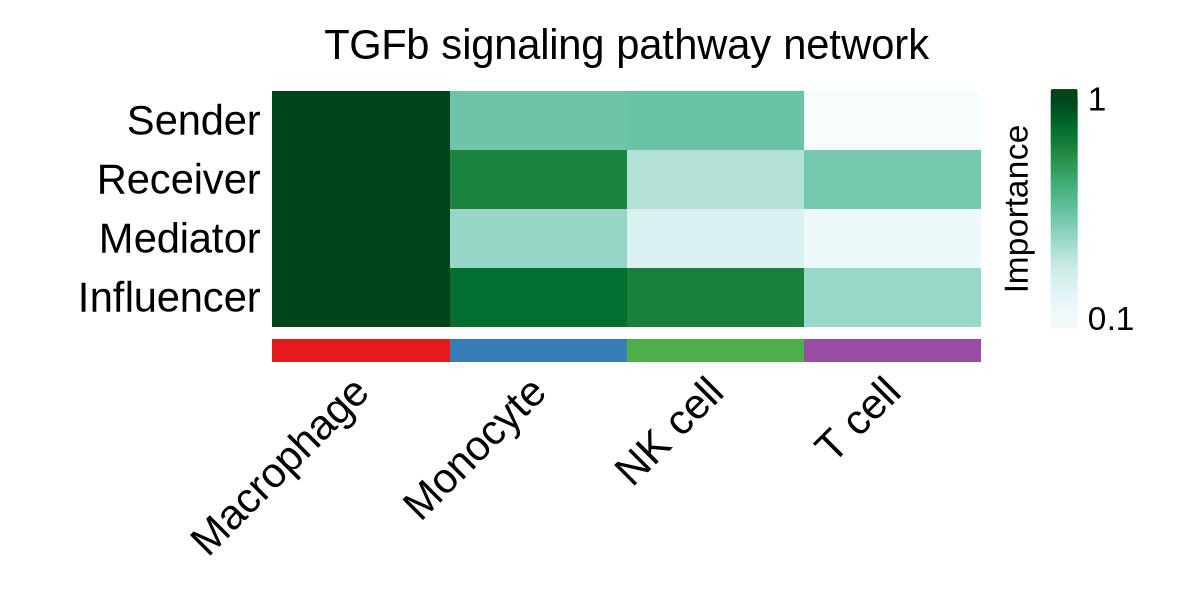

In [24]:
pathways.show <- "TGFb"
netAnalysis_signalingRole_network(cellchat_PF, signaling = pathways.show, width = 6, height = 2, font.size = 10)

In [25]:
options(repr.plot.width = 4, repr.plot.height = 4, repr.plot.res = 220)

Comparing communications on a single object 




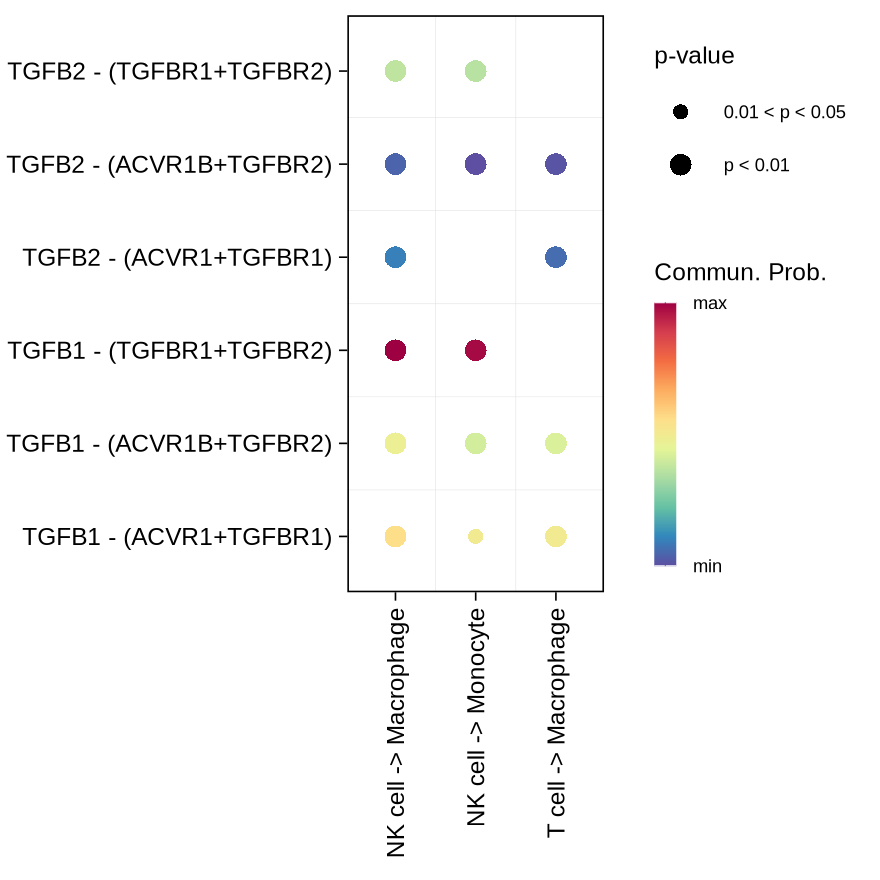

In [26]:
netVisual_bubble(cellchat_PF, sources.use = c(3:4), targets.use = c(1:2), signaling = c("TGFb"), remove.isolate = TRUE) +
    theme(plot.margin = margin(5, 5, 5, 10)) # prevent y-axis label clipping

In [27]:
options(repr.plot.width = 5, repr.plot.height = 5)

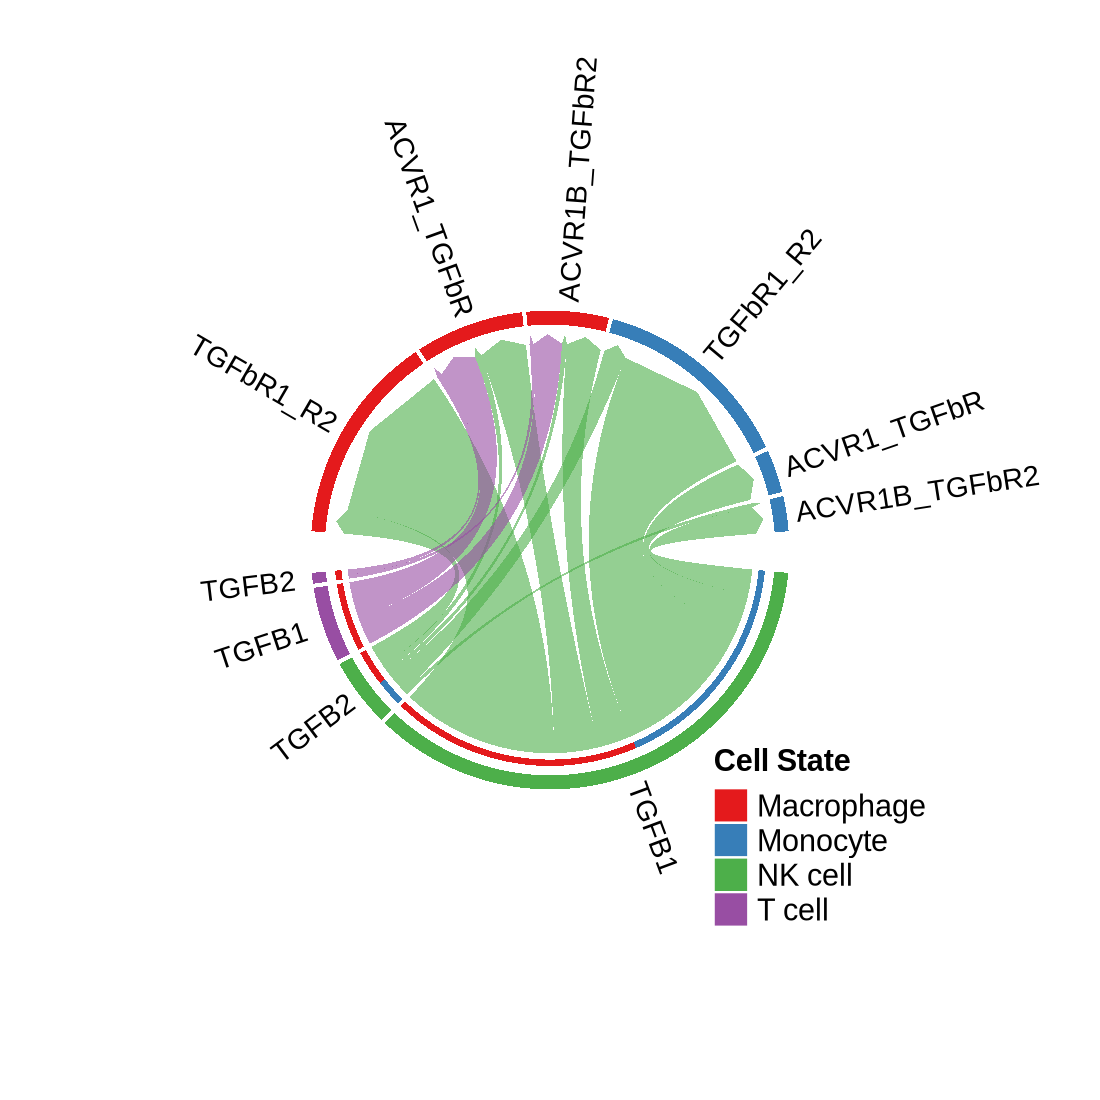

In [28]:
plot <- netVisual_chord_gene(cellchat_PF, sources.use = c(3:4), targets.use = c(1:2), signaling = c("TGFb"))

## Process same process for normal group

### 1. Input data processing & Running CellChat

In [29]:
seurat_NM <- subset(seurat, subset = disease == "normal")
cellchat_NM <- createCellChat(object = seurat_NM, group.by = "celltype", assay = "RNA")

cellchat_NM@DB <- CellChatDB

cellchat_NM <- subsetData(cellchat_NM)

cellchat_NM <- identifyOverExpressedGenes(cellchat_NM)
cellchat_NM <- identifyOverExpressedInteractions(cellchat_NM)

cellchat_NM <- smoothData(cellchat_NM, adj = PPI.human)

cellchat_NM <- computeCommunProb(cellchat_NM, raw.use = FALSE)
cellchat_NM <- filterCommunication(cellchat_NM, min.cells = 0)
cellchat_NM <- computeCommunProbPathway(cellchat_NM)
cellchat_NM <- aggregateNet(cellchat_NM)

[1] "Create a CellChat object from a Seurat object"
The `meta.data` slot in the Seurat object is used as cell meta information 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  T cell, NK cell, Macrophage, Monocyte 
The number of highly variable ligand-receptor pairs used for signaling inference is 907 
triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2025-07-19 21:37:24.11691]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2025-07-19 21:39:12.73286]"


### 2. Visualization

In [30]:
options(repr.plot.width = 5, repr.plot.height = 5)

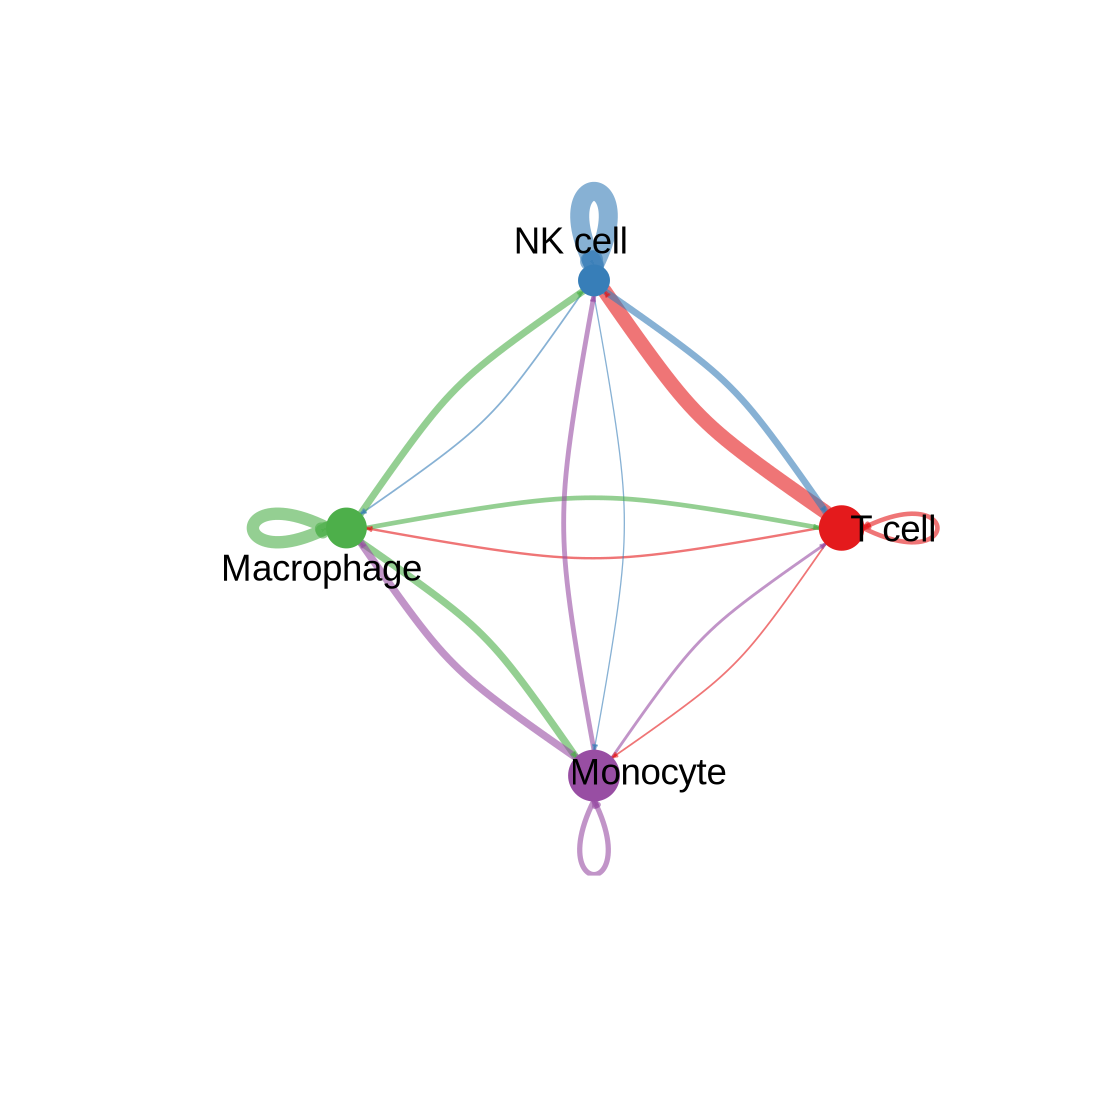

In [31]:
groupSize_NM <- as.numeric(table(cellchat_NM@idents))
plt <- netVisual_circle(cellchat_NM@net$weight, vertex.weight = groupSize_NM,
                 weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

In [32]:
options(repr.plot.width = 4, repr.plot.height = 2, repr.plot.res = 300)

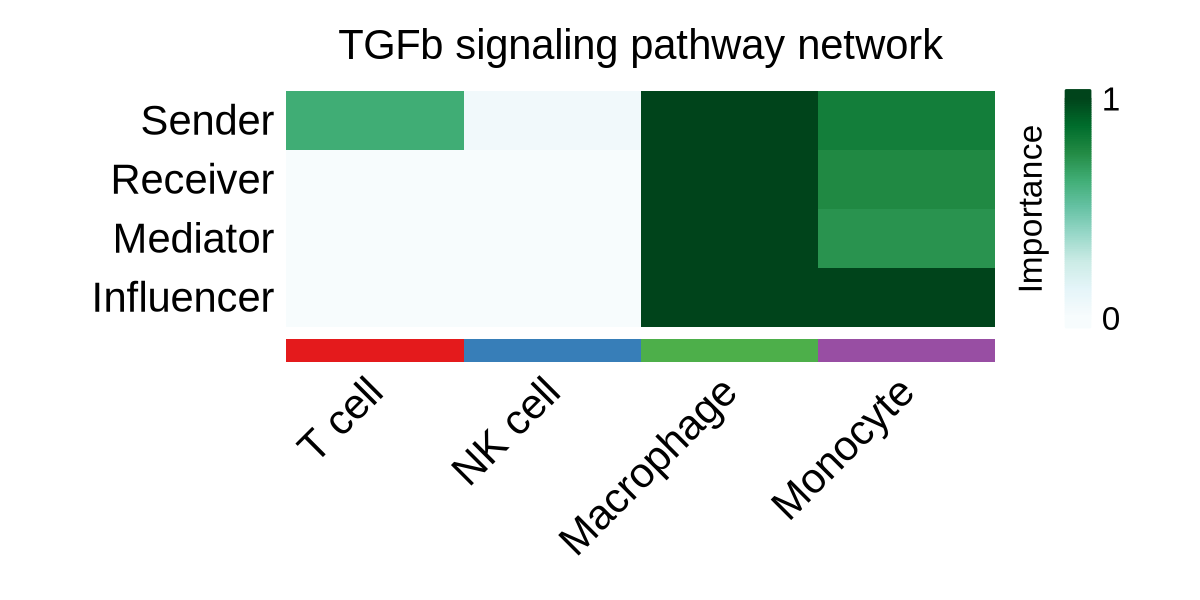

In [33]:
# Compute centrality
cellchat_NM <- netAnalysis_computeCentrality(cellchat_NM, slot.name = "netP")

pathways.show <- "TGFb"
netAnalysis_signalingRole_network(cellchat_NM, signaling = pathways.show, width = 6, height = 2, font.size = 10)

## Reference

Jin, S., Guerrero-Juarez, C. F., Zhang, L., Chang, I., Ramos, R., Kuan, C. H., … & Nie, Q. (2021). Inference and analysis of cell-cell communication using CellChat. Nature communications, 12(1), 1-20.

Jin, S., Plikus, M.V. & Nie, Q. (2025). CellChat for systematic analysis of cell–cell communication from single-cell transcriptomics. Nat Protoc, 20, 180–219.

Sikkema, L., Ramírez-Suástegui, C., Strobl, D.C., … & Theis, F.J. (2023). An integrated cell atlas of the lung in health and disease. Nat Med, 29, 1563–1577.

In [34]:
sessionInfo()

R version 4.4.3 (2025-02-28)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 24.04.2 LTS

Matrix products: default
BLAS/LAPACK: /BiO/prog/miniforge3/envs/CCI/lib/libopenblasp-r0.3.30.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Seoul
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] future_1.58.0       CellChat_2.1.2      Biobase_2.66.0     
 [4] BiocGenerics_0.52.0 ggplot2_3.5.2       igraph_2.0.3       
 [7] dplyr_1.1.4         Seurat_5.1.0        SeuratObject_5.1.0 
[10] sp_2.2-0           

loaded via a namespac